# Sector Analytics
Rukmal Weerawarana, Yuzhen He,  Yiyi Zhu

## Notebook Setup

This section contains code to set up the functionality of the notebook (package imports, utility functions, etc.).

### Package Installation

This section contains logic for installing required packages.

In [4]:
# Installing PyDrive (for Google Drive ops)
!pip install -U PyDrive

     |████████████████████████████████| 993kB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


### Jupyter Configuration

Suppress warnings.

In [0]:
import warnings

warnings.filterwarnings('ignore')

### Module Imports

This section contains module imports used by this script. Modules are grouped by their functionality for clarity.

In [0]:
# Google Drive file loading/exporting
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Formatting
from IPython.display import display, HTML

# Type hints
from typing import Callable

# Data loading
from io import StringIO
import os
import pickle

# Data manipulation
import pandas as pd

# Plot
import matplotlib.pyplot as plt

### Authentication

This section contains logic to authenticate the user with Google Drive. Follow the prompts here for Google Drive operations to function correctly.

This functionality is adapted from the official Google Colab guide on handling external data, which can be found [here](https://colab.research.google.com/notebooks/io.ipynb).

In [0]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Data Loading

This section contains logic for data loading operations (from Google Drive).

#### File IDs

This section explicitly lists Google Drive IDs of target folders used in data operations.

In [0]:
sector_backtest_excel = '16-9XHBiNLYqIUUB015iGzeaieYpKIiSj'

#### Download File by Google Drive ID

The function below downloads the file to the local (i.e. Google Colab VM) filesystem, with the same name as on Google Drive. This functionality is implemented using the `PyDrive` package, whose documentation is [here](https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html).

In [0]:
def downloadFileByID(file_id: str, filename: str) -> StringIO:
  # Getting file from Google Drive
  downloaded_file = drive.CreateFile({'id': file_id})
  
  # Saving to local file
  downloaded_file.GetContentFile(filename=filename)

#### Load all Sector Excel Files

This section contains logic to load all excel backtest files (for all sectors) from Google Drive (may take a while...).

In [10]:
# Creating and switching to new directory for pickle files
os.mkdir('excel_backtest')
os.chdir('excel_backtest')

# Getting list of pickled data files
file_list = drive.ListFile({
    'q': "'{0}' in parents and trashed=false".format(
    sector_backtest_excel)}).GetList()

print('Found {0} candidate files on Google Drive'.format(len(file_list)))

counter = 1

print('Downloading excel files from Google Drive to local (VM) filesystem')

for f in file_list:
  print('Downloading file {0} out of {1}'.format(counter, len(file_list)))
  # Downloading file by ID (setting filename to file ID)
  downloadFileByID(file_id=f['id'], filename=f['title'])
  print('Excel file download {0}% complete'.format(counter / len(file_list) * 100))
  counter += 1

Found 61 candidate files on Google Drive
Excel file download 1.639344262295082% complete
Excel file download 3.278688524590164% complete
Excel file download 4.918032786885246% complete
Excel file download 6.557377049180328% complete
Excel file download 8.19672131147541% complete
Excel file download 9.836065573770492% complete
Excel file download 11.475409836065573% complete
Excel file download 13.114754098360656% complete
Excel file download 14.754098360655737% complete
Excel file download 16.39344262295082% complete
Excel file download 18.0327868852459% complete
Excel file download 19.672131147540984% complete
Excel file download 21.311475409836063% complete
Excel file download 22.950819672131146% complete
Excel file download 24.59016393442623% complete
Excel file download 26.229508196721312% complete
Excel file download 27.86885245901639% complete
Excel file download 29.508196721311474% complete
Excel file download 31.147540983606557% complete
Excel file download 32.78688524590164% c

### Build DataFrame with Column

This function builds a DataFrame with a specific column, from each of the pickled dataframes. The title of each column in the resulting DataFrame corresponds to the filename of the pickle file (minus the `.pickle`) extension.

In [0]:
def buildDataFrameWithColumn(col_name: str) -> pd.DataFrame:
  # Iterate through each of the files in the folder
  # NOTE: Should already be in the directory containing excel files
  files = os.listdir('.')
  
  # Isolating excel files
  files = [f for f in files if f.endswith('.xlsx')]
  
  print('Found {0} excel files'.format(len(files)))
  
  # Output DataFrame
  out = pd.DataFrame()
  
  counter = 1
  
  for f in files:
    sector_universe_name = f.split('.')[0]
    
    # Do not add to DataFrame if SP500 (benchmark)
    if (sector_universe_name == 'sp500'):
      pass
    
    print('Loading data from sector universe file {0}'.format(sector_universe_name))
    
    df = pd.read_excel(f)
    
    out[sector_universe_name] = df[col_name]
    
    print('Excel file data extraction {0}% complete'.format(counter / len(files) * 100))
    
    counter += 1
  
  return out

Function to load the benchmark dataset.

In [0]:
def loadBenchmark() -> pd.DataFrame:
  return pd.read_excel('sp500.xlsx')

## Portfolio Turnover Analysis

In this section, we inspect the (cumulative) total portfolio turnover incurred by each of the sectorization schemes over time.

### Building DataFrame

Here, we build a DataFrame with the relevant data (i.e. column `total_port_rebal_turnover`).

In [0]:
port_rebal_turnover = buildDataFrameWithColumn(col_name='total_port_rebal_turnover')

In [0]:
port_rebal_turnover.cumsum().iloc[-1].argmin()

'single_2017_5'

In [0]:
sp500 = loadBenchmark()['total_port_rebal_turnover']
port = port_rebal_turnover['complete_2017_16']

fig, ax = plt.subplots()
ax.plot(sp500, label='GICS')
ax.plot(port, label='Complete_16')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Rebalanc')

Text(0, 0.5, 'Portfolio Rebalancing Turnover')

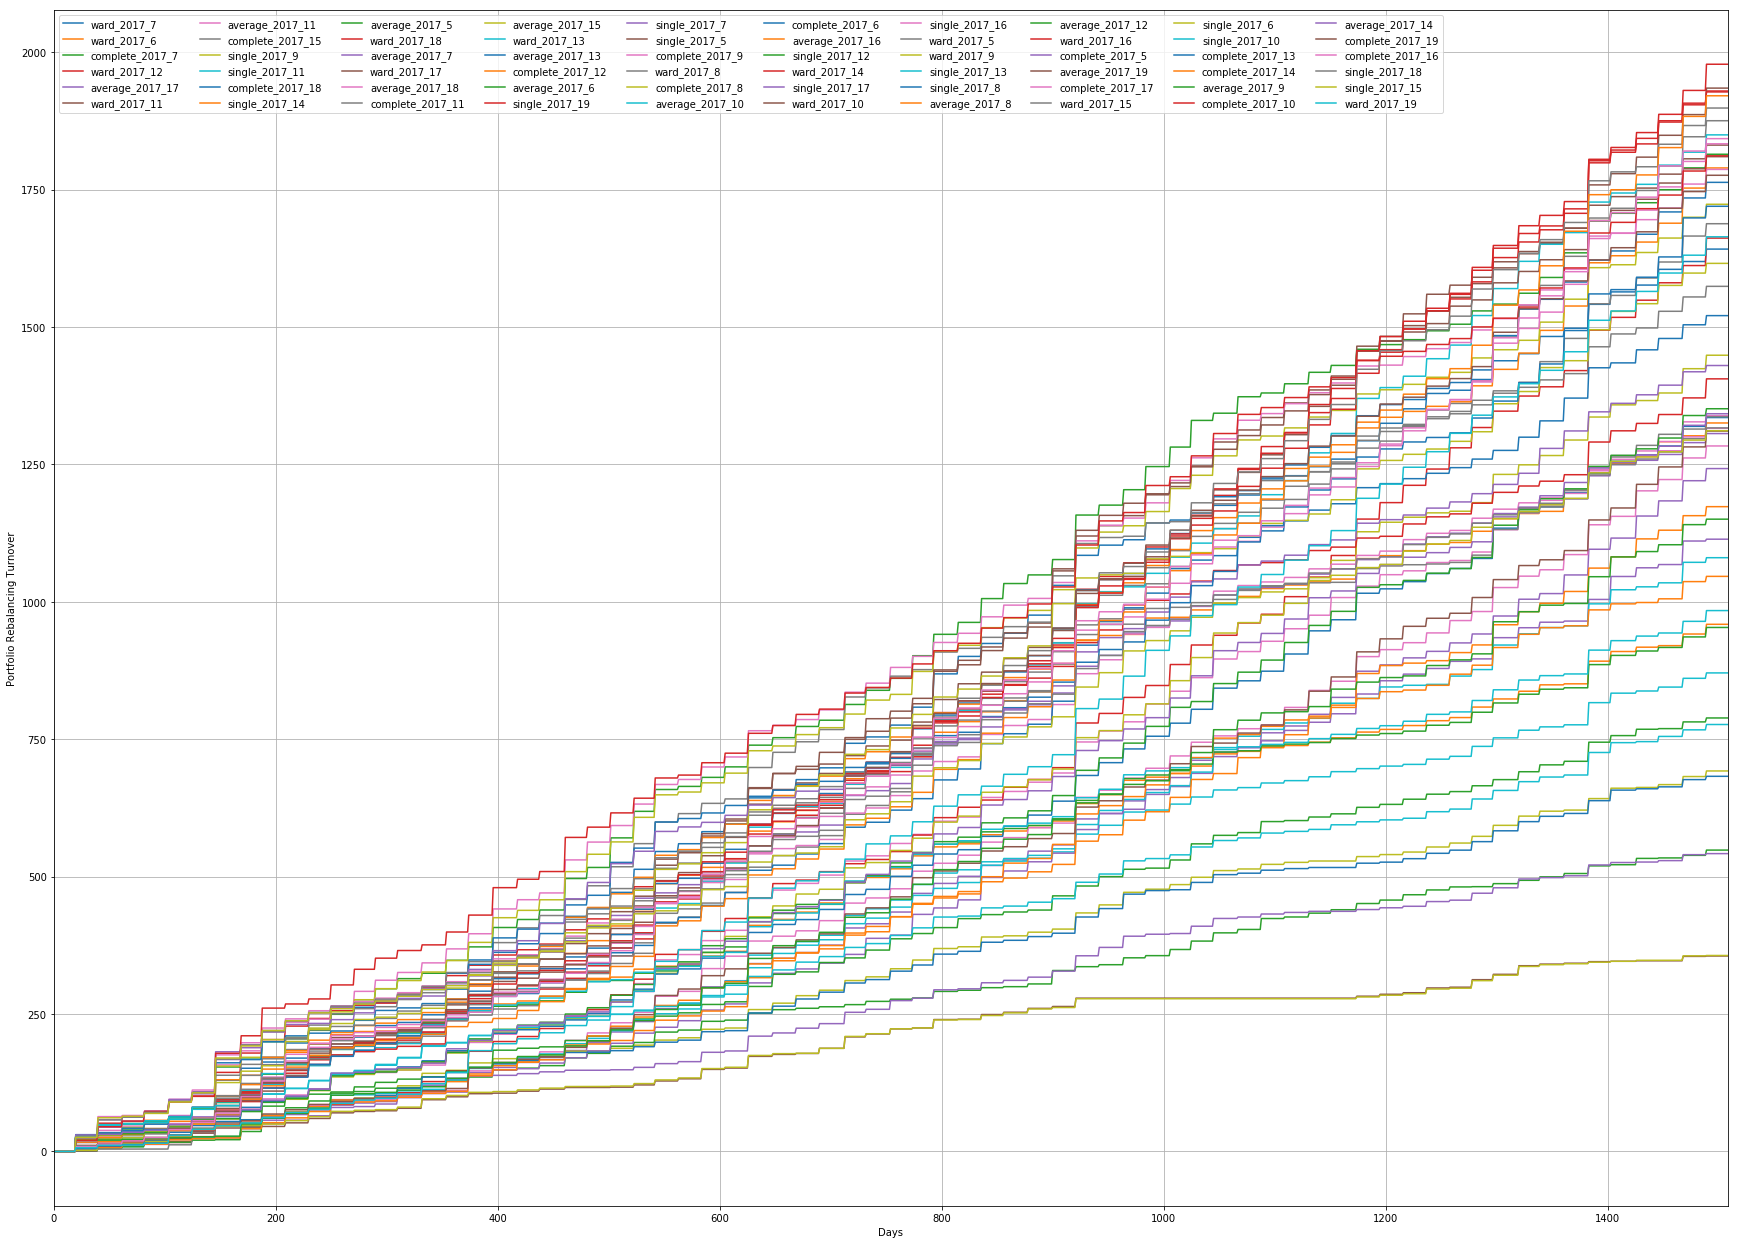

In [0]:
fig, ax = plt.subplots(figsize=(30, 22))
port_rebal_turnover.cumsum().plot(ax=ax, grid=True, sharey=True)
ax.legend(loc='upper left', ncol=10)
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Rebalancing Turnover')

## ETF Restructuring Turnover Analysis

In this section, we inspect the (cumulative) total ETF restructuring turnover incurred by each of the sectorization schemes over time.

### Building DataFrame

Here, we build a DataFrame with the relevant data (i.e. column `total_etf_restr_turnover`).

In [0]:
etf_restr_turnover = buildDataFrameWithColumn(col_name='total_etf_restr_turnover')

In [0]:
etf_restr_turnover.cumsum().iloc[-1].argmin()

'single_2017_5'

Text(0, 0.5, 'ETF Restructuring Turnover')

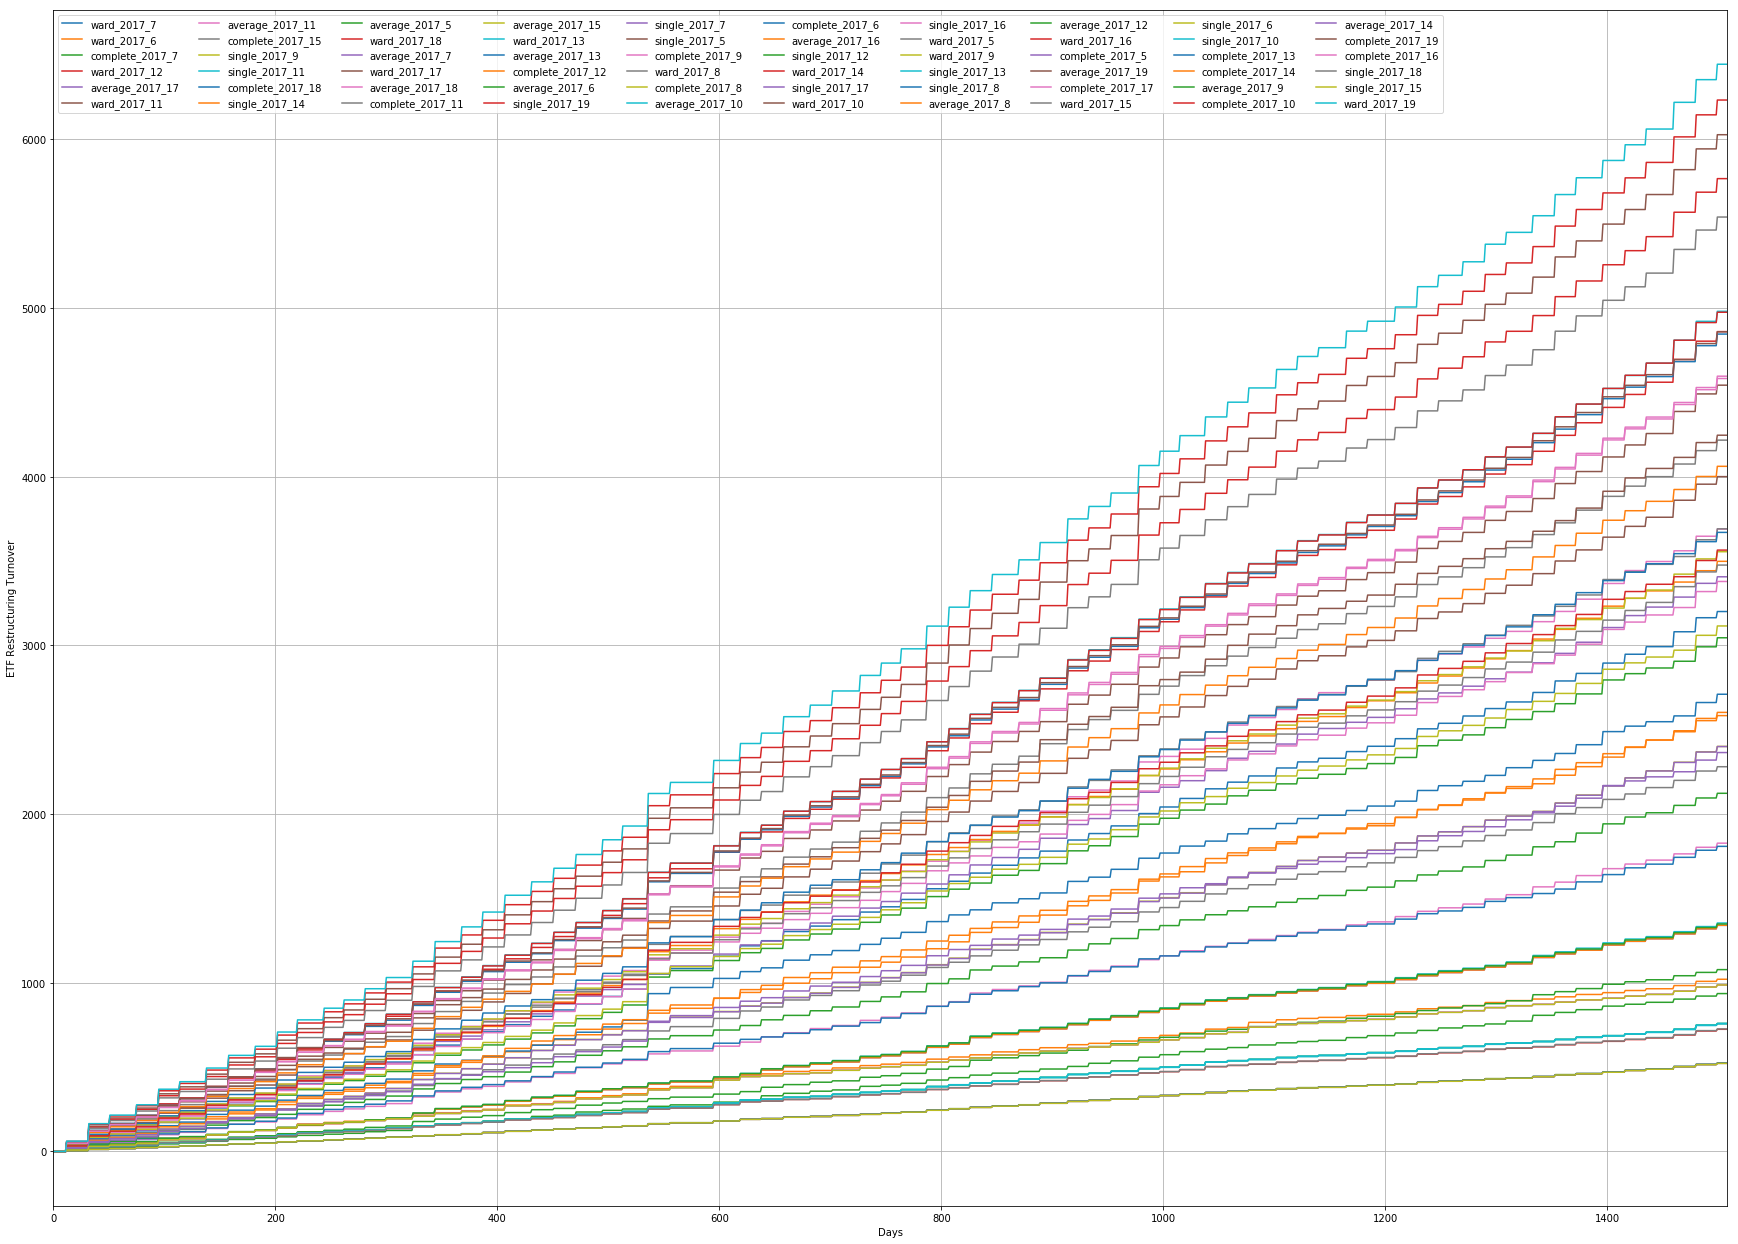

In [0]:
fig, ax = plt.subplots(figsize=(30, 22))
etf_restr_turnover.cumsum().plot(ax=ax, grid=True, sharey=True)
ax.legend(loc='upper left', ncol=10)
ax.set_xlabel('Days')
ax.set_ylabel('ETF Restructuring Turnover')

## Sharpe Ratio Analysis

In [0]:
sharpe_ratio_df = buildDataFrameWithColumn(col_name='sharpe')

In [14]:
sharpe_ratio_df.iloc[-1].argmax()

'complete_2017_16'

Text(0, 0.5, 'Sharpe Ratio')

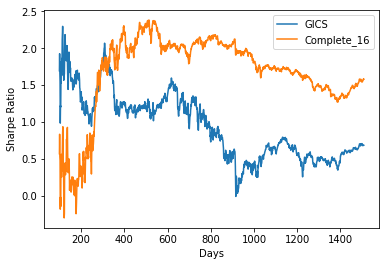

In [26]:
sp500 = loadBenchmark()['sharpe']
port = sharpe_ratio_df[sharpe_ratio_df.iloc[-1].argmax()]

fig, ax = plt.subplots()
ax.plot(sp500[100:], label='GICS')
ax.plot(port[100:], label='Complete_16')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Sharpe Ratio')

In [0]:
fig, ax = plt.subplots(figsize=(30, 22))
sharpe_ratio_df.iloc[100:].plot(ax=ax, grid=True, sharey=True)
ax.legend(loc='upper right', ncol=10)
ax.set_xlabel('Days')
ax.set_ylabel('Sharp Ratio')

Output hidden; open in https://colab.research.google.com to view.

## Portfolio Value Analysis

In [28]:
port_value_df = buildDataFrameWithColumn(col_name='portfolio_value')

Found 61 excel files
Loading data from sector universe file ward_2017_7
Excel file data extraction 1.639344262295082% complete
Loading data from sector universe file ward_2017_6
Excel file data extraction 3.278688524590164% complete
Loading data from sector universe file complete_2017_7
Excel file data extraction 4.918032786885246% complete
Loading data from sector universe file ward_2017_12
Excel file data extraction 6.557377049180328% complete
Loading data from sector universe file average_2017_17
Excel file data extraction 8.19672131147541% complete
Loading data from sector universe file ward_2017_11
Excel file data extraction 9.836065573770492% complete
Loading data from sector universe file average_2017_11
Excel file data extraction 11.475409836065573% complete
Loading data from sector universe file complete_2017_15
Excel file data extraction 13.114754098360656% complete
Loading data from sector universe file single_2017_9
Excel file data extraction 14.754098360655737% complete
Lo

In [0]:
port_value_df.iloc[-1].argmax()

'complete_2017_9'

Text(0, 0.5, 'Portfolio Value')

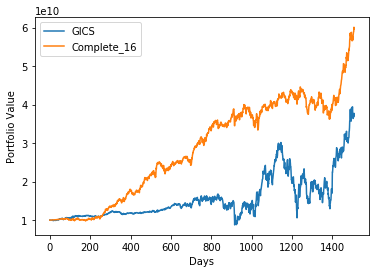

In [29]:
sp500 = loadBenchmark()['portfolio_value']
port = port_value_df['complete_2017_16']

fig, ax = plt.subplots()
ax.plot(sp500, label='GICS')
ax.plot(port, label='Complete_16')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Value')

Text(0, 0.5, 'Portfolio Value')

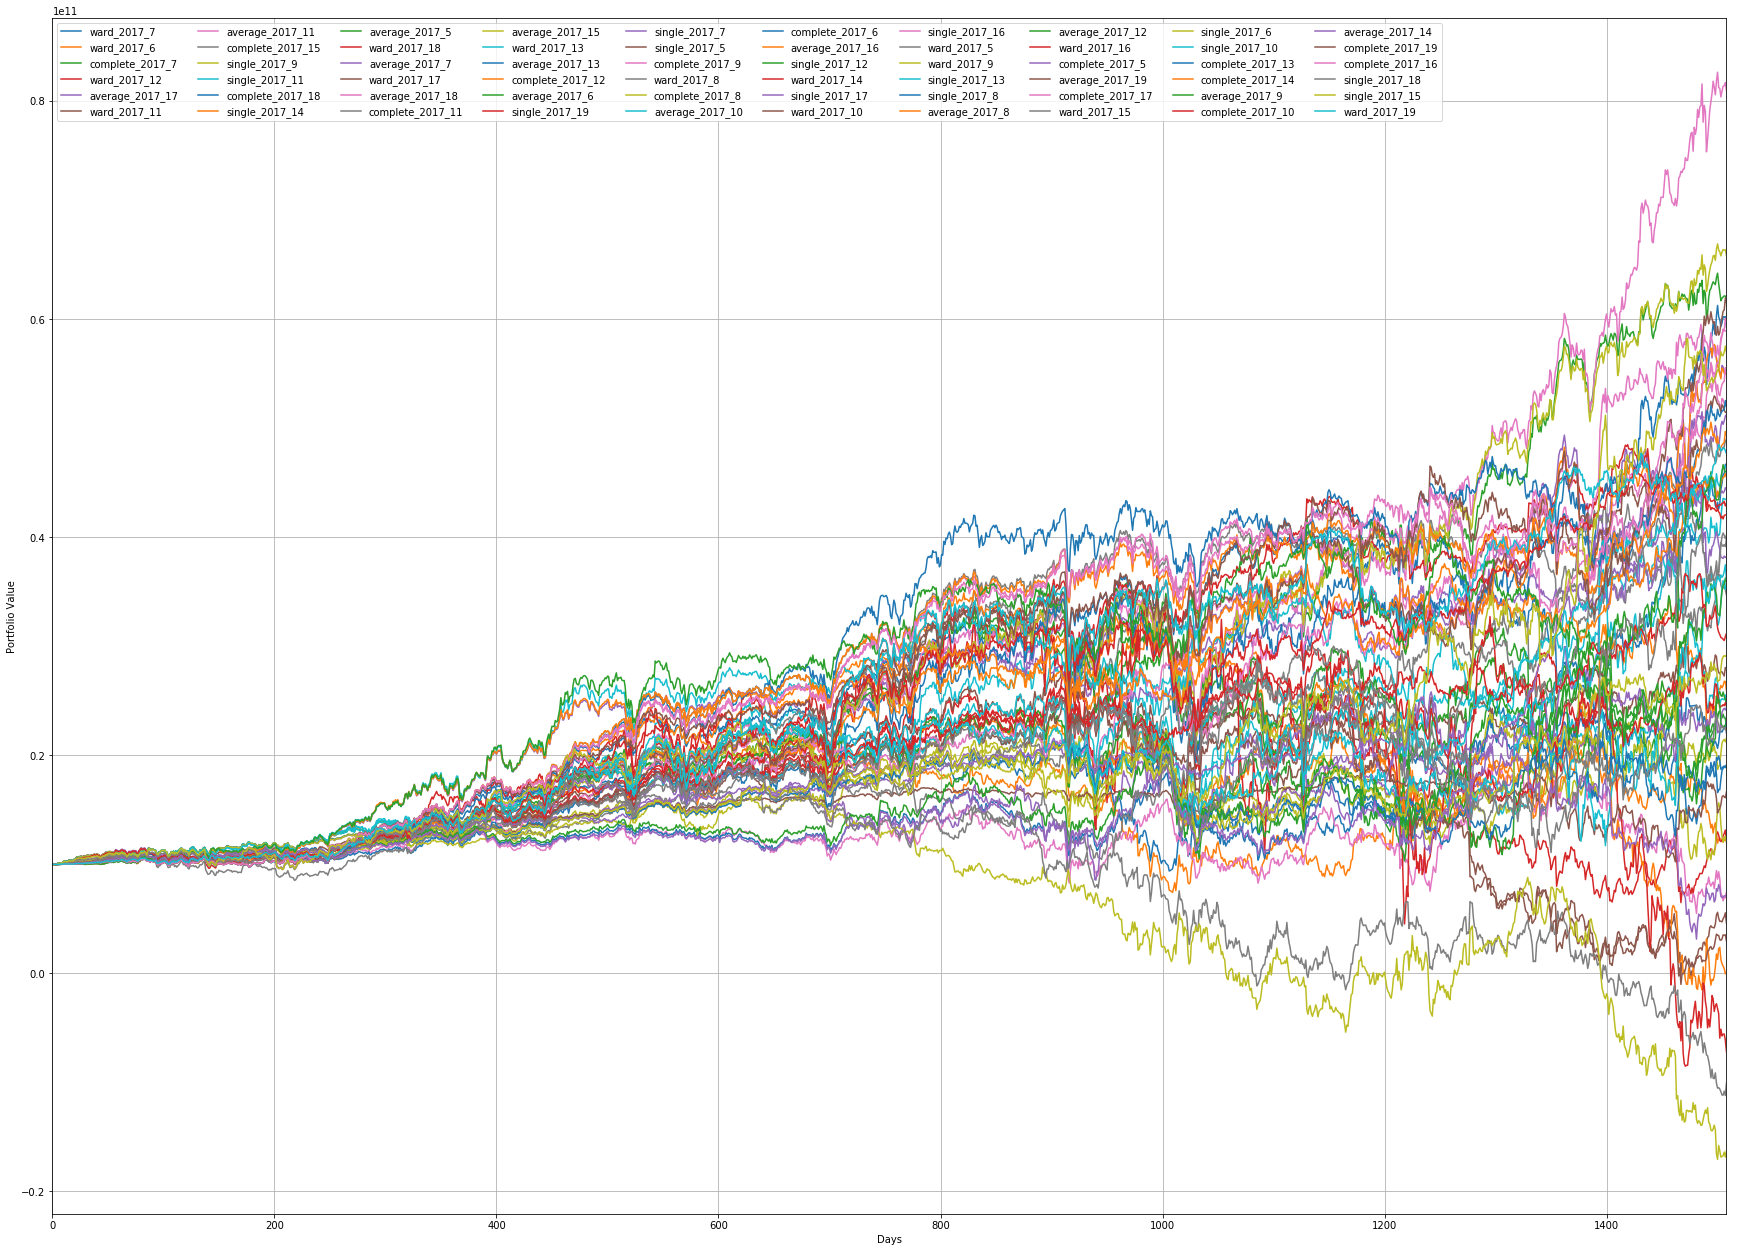

In [0]:
fig, ax = plt.subplots(figsize=(30, 22))
port_value_df.plot(ax=ax, grid=True, sharey=True)
ax.legend(loc='upper left', ncol=10)
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Value')

Portfolio Turnover MIN: single 5  
ETF Restructuring Turnover MIN: single 5  
Sharp Ratio MAX: complete 16  
Portfolio Value MAX: complete 9  

